# EMTAB9817 - preprocessing
## Xiaonan Wang
## 01Jun2022

In [1]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
import anndata
import seaborn as sns

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.19.5 scipy==1.5.4 pandas==1.1.5 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.0 leidenalg==0.8.3


# Data in

In [2]:
FileDir = '/nfs01data1/Groups/Wangxiaonan/share/rev_MI/EMTAB9817'

In [3]:
meta = pd.read_csv('E-MTAB-9817.sdrf.txt', index_col=0, sep='\t')

In [4]:
# remove duplicates due to paired end sequencing R1,R2
meta = meta.drop_duplicates(subset=['Comment[ENA_SAMPLE]'])

In [5]:
meta.columns

Index(['Comment[ENA_SAMPLE]', 'Comment[BioSD_SAMPLE]',
       'Characteristics[organism]', 'Characteristics[strain]',
       'Characteristics[age]', 'Unit[time unit]', 'Term Source REF',
       'Term Accession Number', 'Characteristics[developmental stage]',
       'Characteristics[sex]', 'Characteristics[genotype]',
       'Characteristics[organism part]', 'Characteristics[individual]',
       'Characteristics[disease]', 'Characteristics[time]',
       'Unit[time unit].1', 'Term Source REF.1', 'Term Accession Number.1',
       'Material Type', 'Protocol REF', 'Protocol REF.1', 'Protocol REF.2',
       'Extract Name', 'Comment[LIBRARY_LAYOUT]', 'Comment[LIBRARY_SELECTION]',
       'Comment[LIBRARY_SOURCE]', 'Comment[LIBRARY_STRATEGY]',
       'Comment[cdna read]', 'Comment[cdna read offset]',
       'Comment[cdna read size]', 'Comment[cell barcode offset]',
       'Comment[cell barcode read]', 'Comment[cell barcode size]',
       'Comment[end bias]', 'Comment[input molecule]',
       '

In [9]:
meta1 = meta[['Characteristics[organism]', 'Characteristics[strain]', 'Characteristics[age]', 'Characteristics[developmental stage]', 'Characteristics[sex]','Characteristics[genotype]', 'Derived Array Data File.2','Factor Value[disease]', 'Comment[ENA_RUN]','Characteristics[organism part]']]

In [10]:
meta1.columns = ['Organism', 'Strain', 'Age', 'Development_stage', 'Gender', 'Genotype',  'Filename','Condition','ERR','Tissue']

In [11]:
meta1

,Organism,Strain,Age,Development_stage,Gender,Genotype,Filename,Condition,ERR,Tissue
Source Name,,,,,,,,,,
Sample 1,Mus musculus,Col1a2-CreERT2;mT/mG,88 to 91,adult,male,Col1a2-CreERT2/+; mT/mG,103992-001-001_genes.tsv.gz,myocardial infarction,ERR4901831,heart
Sample 3,Mus musculus,Col1a2-CreERT2;mT/mG,88 to 91,adult,male,Col1a2-CreERT2/+; mT/mG,103992-001-003_genes.tsv.gz,myocardial infarction,ERR4901832,heart
Sample 5,Mus musculus,Col1a2-CreERT2;mT/mG,12,adult,male,Col1a2-CreERT2/+; mT/mG,103992-001-005_genes.tsv.gz,myocardial infarction,ERR4901833,heart
Sample 6,Mus musculus,Col1a2-CreERT2;mT/mG,12,adult,male,Col1a2-CreERT2/+; mT/mG,103992-001-006_genes.tsv.gz,myocardial infarction,ERR4901834,heart
Sample 2,Mus musculus,Col1a2-CreERT2;mT/mG,88 to 91,adult,male,Col1a2-CreERT2/+; mT/mG,103992-001-002_genes.tsv.gz,normal,ERR4901835,heart
Sample 4,Mus musculus,Col1a2-CreERT2;mT/mG,88 to 91,adult,male,Col1a2-CreERT2/+; mT/mG,103992-001-004_genes.tsv.gz,normal,ERR4901836,heart
Sample 7,Mus musculus,Col1a2-CreERT2;mT/mG,12,adult,male,Col1a2-CreERT2/+; mT/mG,103992-001-007_genes.tsv.gz,normal,ERR4901837,heart
Sample 8,Mus musculus,Col1a2-CreERT2;mT/mG,12,adult,male,Col1a2-CreERT2/+; mT/mG,103992-001-008_genes.tsv.gz,normal,ERR4901838,heart


In [12]:
meta1 = meta1.assign(StudyID = 'EMTAB9817')
meta1 = meta1.assign(Index=[x[:14] for x in meta1['Filename']])
meta1.drop('Filename', axis=1, inplace=True)

In [15]:
adata = []
for idx, row in meta1.iterrows():
    adata_sub = sc.read_10x_mtx(FileDir, prefix=row['Index']+'_', cache=True)
    adata_sub.obs['Organism'] = row['Organism']
    adata_sub.obs['Strain'] = row['Strain']
    adata_sub.obs['Age'] = row['Age']
    adata_sub.obs['Development_stage'] = row['Development_stage']
    adata_sub.obs['Gender'] = row['Gender']
    adata_sub.obs['Genotype'] = row['Genotype']
    adata_sub.obs['CellType'] = 'Col1a2-CreERT2/+; mT/mG'
    adata_sub.obs['Condition'] = row['Condition']
    adata_sub.obs['Day'] = 28
    adata_sub.obs['ERR'] = row['ERR']
    adata_sub.obs['Tissue'] = row['Tissue']
    adata_sub.obs['StudyID'] = row['StudyID']
    adata_sub.obs['Index'] = row['Index']
    adata.append(adata_sub)
    del adata_sub

... reading from cache file cache/nfs01data1-Groups-Wangxiaonan-share-rev_MI-EMTAB9817-103992-001-001_matrix.h5ad
... reading from cache file cache/nfs01data1-Groups-Wangxiaonan-share-rev_MI-EMTAB9817-103992-001-003_matrix.h5ad
... writing an h5ad cache file to speedup reading next time
... writing an h5ad cache file to speedup reading next time
... writing an h5ad cache file to speedup reading next time
... writing an h5ad cache file to speedup reading next time
... writing an h5ad cache file to speedup reading next time
... writing an h5ad cache file to speedup reading next time


# Doublet removal

In [16]:
import scrublet as scr

In [17]:
scrub_obj = []
for i in range(len(adata)):
    scrub = scr.Scrublet(adata[i].X.toarray())
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    adata[i].obs['db_scores'] = doublet_scores
    adata[i].obs['predicted_db'] = predicted_doublets
    scrub_obj.append(scrub)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.45
Detected doublet rate = 0.6%
Estimated detectable doublet fraction = 31.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.8%
Elapsed time: 4.8 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 18.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.2%
Elapsed time: 1.8 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.45
Detected doublet rate = 1.0%
Estimated detectable doublet fraction = 25.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.0%
Elapsed time: 3.6 seconds
Preprocessing...
Simulating double

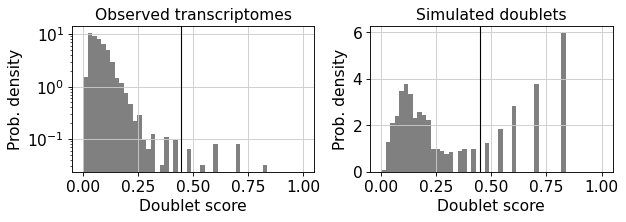

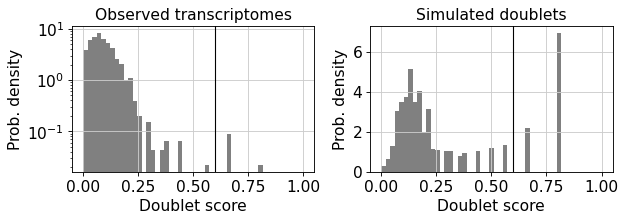

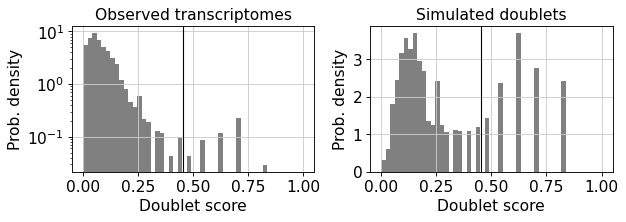

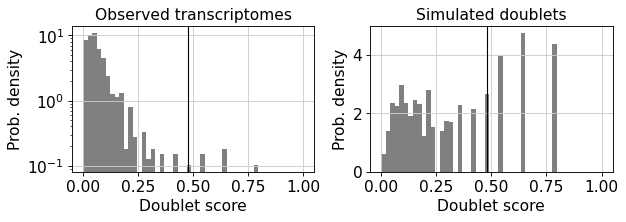

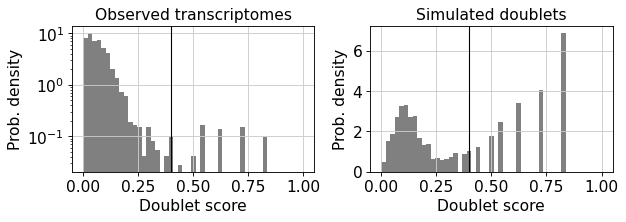

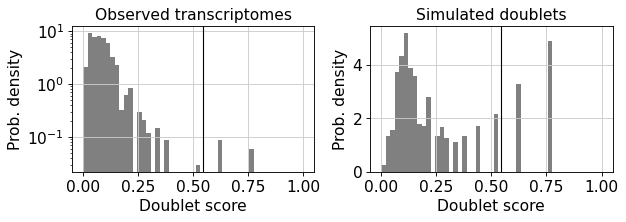

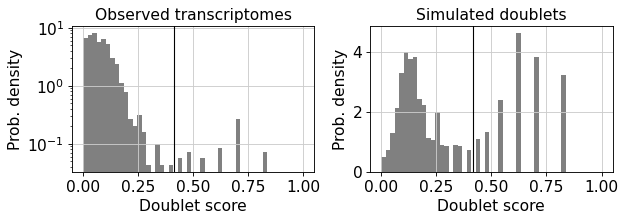

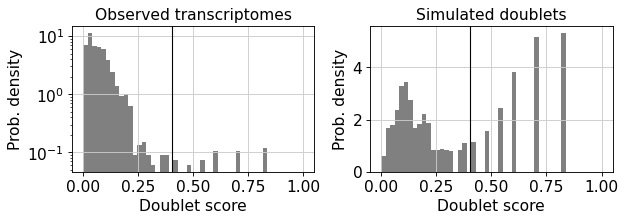

In [18]:
for i in range(len(adata)):
    scrub_obj[i].plot_histogram()

In [19]:
def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

41
['myocardial infarction: Number of doublets = 18']
16
['myocardial infarction: Number of doublets = 5']
53
['myocardial infarction: Number of doublets = 35']
100
['myocardial infarction: Number of doublets = 17']
116
['normal: Number of doublets = 52']
85
['normal: Number of doublets = 5']
59
['normal: Number of doublets = 43']
77
['normal: Number of doublets = 36']


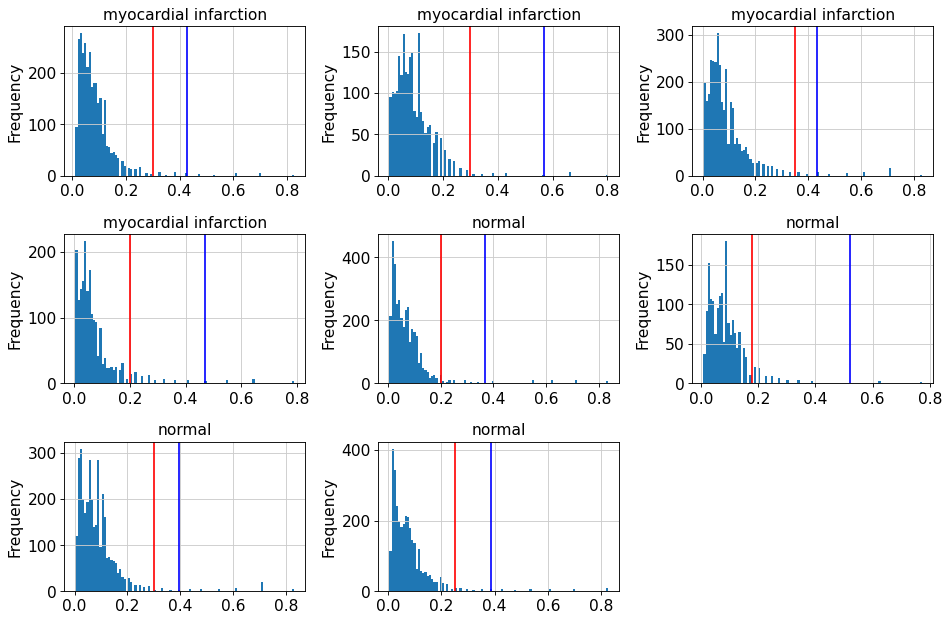

In [23]:
cutoffs = [0.3, 0.3, 0.35, 0.2, 0.2, 0.18, 0.3,0.25]

fig, ax = plt.subplots(3,3, figsize=(12,8))
ax = ax.flatten()
ax = trim_axs(ax, len(adata))
for i in range(len(adata)):    
    pd.DataFrame(adata[i].obs['db_scores']).plot.hist(bins=100, ax=ax[i])
    ax[i].axvline(x=cutoffs[i], color='r')
    ax[i].axvline(x=np.sort(adata[i].obs['db_scores'])[::-1][np.sum(adata[i].obs['predicted_db'])], color='b')
    ax[i].get_legend().remove()
    ax[i].set_title(adata[i].obs['Condition'][0])
    print(np.sum(adata[i].obs['db_scores'] > cutoffs[i]))
    print(np.unique(adata[i].obs['Condition'])+': Number of doublets = '+str(np.sum(adata[i].obs['predicted_db'])))
plt.tight_layout()  

In [24]:
for i in range(len(adata)):
    adata[i].obs['predicted_db'] = adata[i].obs['db_scores'] > cutoffs[i]

In [25]:
# remove doublets
for i in range(len(adata)):
    print(np.unique(adata[i].obs['Condition'])+str(adata[i].shape))
    adata[i] = adata[i][~adata[i].obs['predicted_db'],:].copy()
    print(np.unique(adata[i].obs['Condition'])+str(adata[i].shape))

['myocardial infarction(3085, 28002)']
['myocardial infarction(3044, 28002)']
['myocardial infarction(2252, 28002)']
['myocardial infarction(2236, 28002)']
['myocardial infarction(3410, 28002)']
['myocardial infarction(3357, 28002)']
['myocardial infarction(1923, 28002)']
['myocardial infarction(1823, 28002)']
['normal(3570, 28002)']
['normal(3454, 28002)']
['normal(1674, 28002)']
['normal(1589, 28002)']
['normal(3434, 28002)']
['normal(3375, 28002)']
['normal(3243, 28002)']
['normal(3166, 28002)']


# QC

In [26]:
[x for x in adata[0].var_names if 'mt-' in x]

['mt-Nd1',
 'mt-Nd2',
 'mt-Co1',
 'mt-Co2',
 'mt-Atp8',
 'mt-Atp6',
 'mt-Co3',
 'mt-Nd3',
 'mt-Nd4l',
 'mt-Nd4',
 'mt-Nd5',
 'mt-Nd6',
 'mt-Cytb']

In [27]:
for i in range(len(adata)):
    adata[i].var['mt'] = adata[i].var_names.str.startswith('mt-') 
    sc.pp.calculate_qc_metrics(adata[i], qc_vars=['mt'], inplace=True)

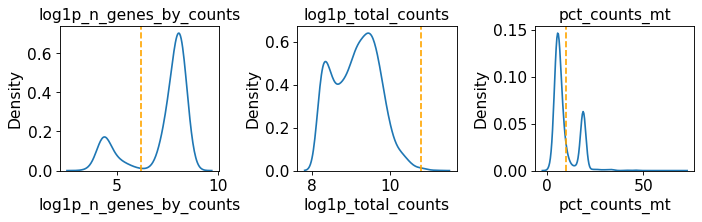

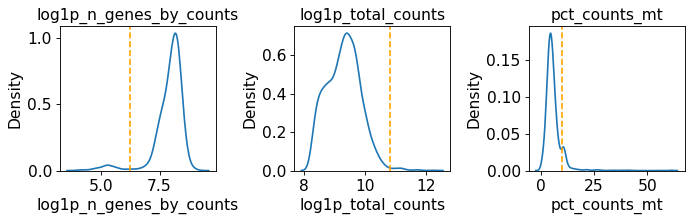

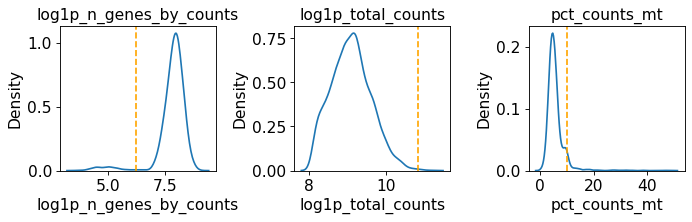

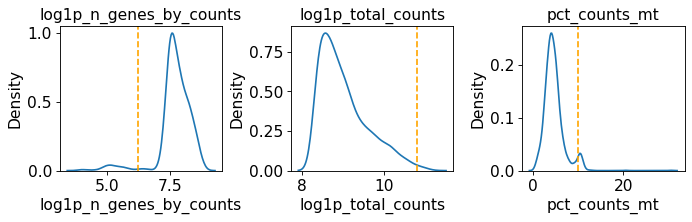

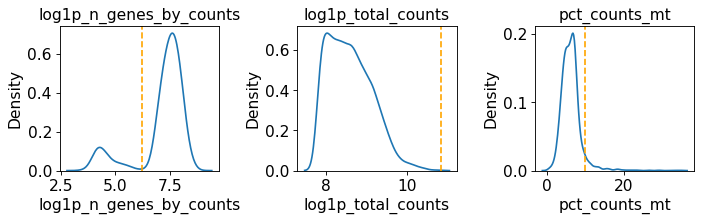

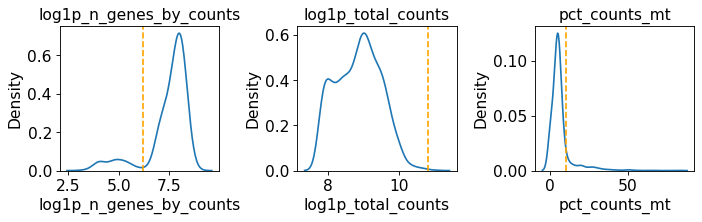

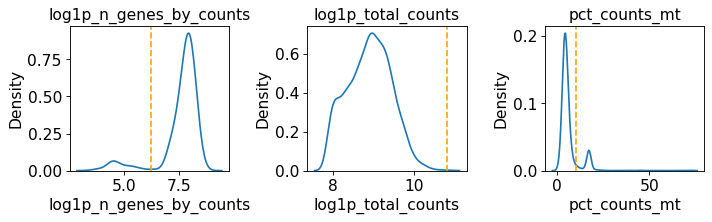

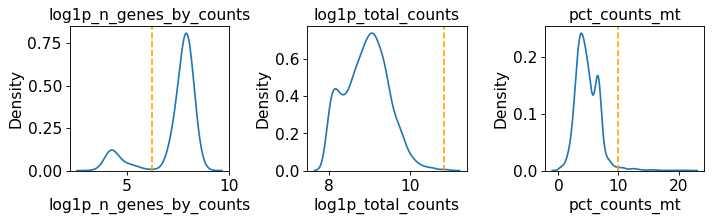

In [31]:
cutoffs = [[500,50000, np.exp(10)],
           [500,50000, np.exp(10)],
           [500,50000, np.exp(10)],
           [500,50000, np.exp(10)],
           [500,50000, np.exp(10)],
           [500,50000, np.exp(10)],
           [500,50000, np.exp(10)],
           [500,50000, np.exp(10)]]
for i in range(len(adata)):
    obs_terms = ['log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_mt']
    fig,ax = plt.subplots(1,3, figsize=(9,3))
    for j in range(len(obs_terms)):
        sns.kdeplot(adata[i].obs[obs_terms[j]], ax=ax[j])
        ax[j].grid(False)
        ax[j].set_title(obs_terms[j])
        ax[j].axvline(np.log1p(cutoffs[i][j]), c='orange', linestyle='--')
    plt.tight_layout()

In [32]:
for i in range(len(adata)):
    sc.pp.filter_cells(adata[i], min_genes=cutoffs[i][0])
    #sc.pp.filter_genes(adata[i], min_cells=1)
    adata[i] = adata[i][(adata[i].obs['total_counts'] <= cutoffs[i][1]) & (adata[i].obs['pct_counts_mt'] <= np.log(cutoffs[i][2])), :].copy()
    print(adata[i].obs['Condition'].value_counts().sort_index())

filtered out 628 cells that have less than 500 genes expressed
filtered out 94 cells that have less than 500 genes expressed
filtered out 134 cells that have less than 500 genes expressed


myocardial infarction    2174
Name: Condition, dtype: int64
myocardial infarction    1974
Name: Condition, dtype: int64


filtered out 78 cells that have less than 500 genes expressed
filtered out 484 cells that have less than 500 genes expressed


myocardial infarction    3073
Name: Condition, dtype: int64
myocardial infarction    1712
Name: Condition, dtype: int64
normal    2800
Name: Condition, dtype: int64


filtered out 175 cells that have less than 500 genes expressed
filtered out 273 cells that have less than 500 genes expressed


normal    1226
Name: Condition, dtype: int64
normal    2967
Name: Condition, dtype: int64


filtered out 457 cells that have less than 500 genes expressed


normal    2650
Name: Condition, dtype: int64


In [33]:
for i in range(len(adata)):
    print(adata[i].shape)

(2174, 28002)
(1974, 28002)
(3073, 28002)
(1712, 28002)
(2800, 28002)
(1226, 28002)
(2967, 28002)
(2650, 28002)


In [34]:
#combine and save the raw counts
adata1 = anndata.AnnData.concatenate(*adata)

In [35]:
adata1.shape

(18576, 28002)

In [36]:
sc.pp.filter_genes(adata1, min_cells=1)

filtered out 6845 genes that are detected in less than 1 cells


In [38]:
adata1.write('./write/EMTAB9817_raw.h5ad')

# Normalisation

In [48]:
adata = sc.read('./write/EMTAB9817_raw.h5ad')

In [49]:
print(adata.shape)

(18576, 21157)


In [50]:
# normalisation
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [51]:
# log counts
sc.pp.log1p(adata)

In [52]:
adata.raw = adata

In [53]:
print(adata.shape)

(18576, 21157)


In [54]:
adata.write('./write/EMTAB9817_lognorm.h5ad')

# Cell Cycle Assignment

In [55]:
adata = sc.read('./write/EMTAB9817_lognorm.h5ad')

In [56]:
print(adata.shape)

(18576, 21157)


In [57]:
cell_cycle_genes = [x.strip()[0].upper()+x.strip()[1:].lower() for x in open('/nfs01data1/Groups/Wangxiaonan/Lab_members/Files/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

97


In [58]:
np.setdiff1d(cell_cycle_genes, adata.raw.var_names)

array(['Mlf1ip'], dtype='<U8')

In [59]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
print('Number of s_genes: '+str(len(s_genes)))
print('Number of g2m_genes: '+str(len(g2m_genes)))
print('Total number of cell cycle genes: '+str(len(cell_cycle_genes)))

Number of s_genes: 43
Number of g2m_genes: 54
Total number of cell cycle genes: 97


In [60]:
ERR = adata.obs['ERR'].cat.categories
print(ERR)

Index(['ERR4901831', 'ERR4901832', 'ERR4901833', 'ERR4901834', 'ERR4901835',
       'ERR4901836', 'ERR4901837', 'ERR4901838'],
      dtype='object')


In [61]:
phase = []
for i in range(len(ERR)):
    adata_sub = adata[adata.obs['ERR'] == ERR[i]].copy()
    print(adata_sub.shape)
    sc.pp.scale(adata_sub)
    sc.tl.score_genes_cell_cycle(adata_sub, s_genes=s_genes, g2m_genes=g2m_genes, use_raw=False)
    phase.append(adata_sub.obs[['phase', 'S_score', 'G2M_score']])

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(2174, 21157)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    771 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    814 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(1974, 21157)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    725 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    859 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(3073, 21157)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    813 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    856 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(1712, 21157)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    772 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    772 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(2800, 21157)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    774 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    817 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
calculating cell cycle phase
computing score 'S_score'


(1226, 21157)


    finished: added
    'S_score', score of gene set (adata.obs).
    815 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    813 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(2967, 21157)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    729 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    858 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(2650, 21157)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    814 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    860 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [62]:
phase_pd = pd.concat(phase)

In [63]:
phase_pd.head()

,phase,S_score,G2M_score
AAACCCACACATGAAA-0,S,0.052577,-0.011958
AAACCCATCAGCGGAA-0,G1,-0.109965,-0.016011
AAACGAACAACGGCTC-0,S,0.214403,-0.104557
AAACGAAGTATTGCCA-0,G2M,-0.142471,0.044087
AAACGAATCCACAGGC-0,S,0.180481,0.128165


In [64]:
print(phase_pd.shape)

(18576, 3)


In [65]:
phase_pd.to_csv('cell_cycle_results.txt')

# Select highly variable genes

In [66]:
adata = sc.read('./write/EMTAB9817_lognorm.h5ad')

In [67]:
cell_cycle_results = pd.read_csv('cell_cycle_results.txt', index_col=0)
adata.obs = pd.concat([adata.obs, cell_cycle_results], axis=1)

In [68]:
adata.obs.head(3)

,Organism,Strain,Age,Development_stage,Gender,Genotype,CellType,Condition,Day,ERR,...,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,n_genes,batch,n_counts,phase,S_score,G2M_score
AAACCCACACATGAAA-0,Mus musculus,Col1a2-CreERT2;mT/mG,88 to 91,adult,male,Col1a2-CreERT2/+; mT/mG,Col1a2-CreERT2/+; mT/mG,myocardial infarction,28,ERR4901831,...,66.890846,1843.0,7.519692,8.917167,4325,0,20668.0,S,0.052577,-0.011958
AAACCCATCAGCGGAA-0,Mus musculus,Col1a2-CreERT2;mT/mG,88 to 91,adult,male,Col1a2-CreERT2/+; mT/mG,Col1a2-CreERT2/+; mT/mG,myocardial infarction,28,ERR4901831,...,74.766234,563.0,6.335054,7.311688,2154,0,7700.0,G1,-0.109965,-0.016011
AAACGAACAACGGCTC-0,Mus musculus,Col1a2-CreERT2;mT/mG,88 to 91,adult,male,Col1a2-CreERT2/+; mT/mG,Col1a2-CreERT2/+; mT/mG,myocardial infarction,28,ERR4901831,...,76.692836,150.0,5.017280,3.680079,1449,0,4076.0,S,0.214403,-0.104557


In [69]:
# find highly variable genes
# parameters are mainly selected depends on user preference
sc.pp.highly_variable_genes(
    adata, min_mean=0.02, max_mean=3, min_disp=0.3, batch_key='batch', inplace=True)

extracting highly variable genes
... storing 'phase' as categorical
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


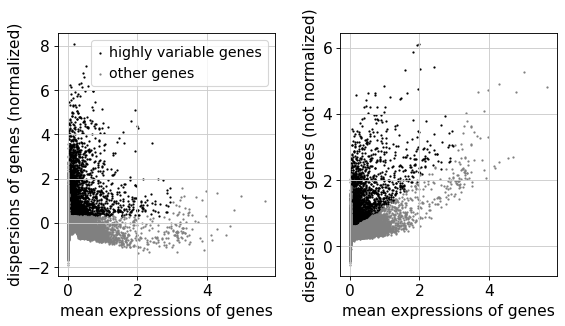

In [70]:
sc.pl.highly_variable_genes(adata)

In [71]:
print(np.sum(adata.var.highly_variable))

2824


In [72]:
adata = adata[:, adata.var.highly_variable].copy()

In [73]:
adata.write('./write/EMTAB9817_lognorm_hvg.h5ad')

# Preliminary processing

In [74]:
adata = sc.read('./write/EMTAB9817_lognorm_hvg.h5ad')

In [75]:
# normally regress out the top layers of unwanted effects
sc.pp.regress_out(adata, ['total_counts','n_genes_by_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'n_genes_by_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:56)


In [76]:
# scale for pca
sc.pp.scale(adata)
# pca
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


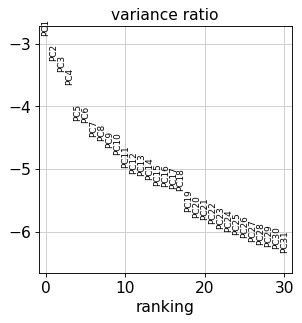

In [77]:
sc.pl.pca_variance_ratio(adata, log=True)

In [78]:
sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)


In [79]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)


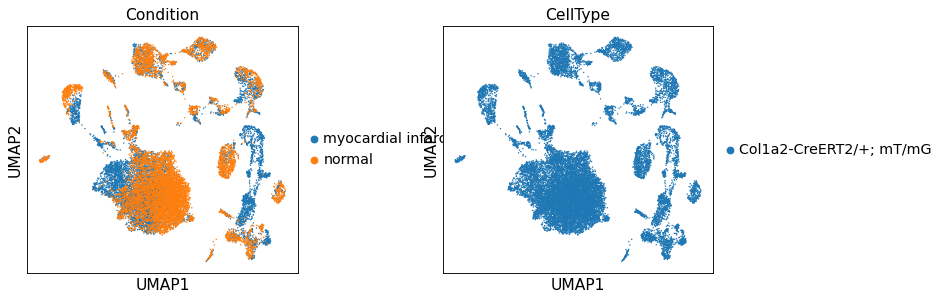

In [82]:
sc.pl.umap(adata, color= ['Condition', 'CellType'], wspace=0.4)

In [83]:
adata.write('./write/EMTAB9817_processed.h5ad')

#  Further modify

In [84]:
adata = sc.read('./write/EMTAB9817_processed.h5ad')

In [85]:
adata.obs['Day'].value_counts()

28    18576
Name: Day, dtype: int64

In [86]:
adata.obs['Day'] = adata.obs['Day'].astype(int)

In [87]:
adata.obs['Age'].value_counts()

12          10402
88 to 91     8174
Name: Age, dtype: int64

In [89]:
adata.obs['Age'] = [90 if '88' in x else x for x in adata.obs['Age']]

In [90]:
adata.obs['Age'].value_counts()

12    10402
90     8174
Name: Age, dtype: int64

In [91]:
adata.obs['Age'] = adata.obs['Age'].astype(int)

In [92]:
adata.obs['Development_stage'].value_counts()

adult    18576
Name: Development_stage, dtype: int64

In [93]:
adata.obs['Genotype'].value_counts()

Col1a2-CreERT2/+; mT/mG    18576
Name: Genotype, dtype: int64

In [94]:
pd.crosstab(adata.obs['Genotype'], adata.obs['CellType'])

CellType,Col1a2-CreERT2/+; mT/mG
Genotype,
Col1a2-CreERT2/+; mT/mG,18576


In [95]:
adata.obs['CellType'] = 'Non-CM'

In [96]:
adata.obs['CellType'].value_counts()

Non-CM    18576
Name: CellType, dtype: int64

In [97]:
adata.obs['StudyID'].value_counts()

EMTAB9816    18576
Name: StudyID, dtype: int64

In [107]:
adata.obs['StudyID'] = 'EMTAB9817'

In [98]:
adata.obs['ERR'].value_counts()

ERR4901833    3073
ERR4901837    2967
ERR4901835    2800
ERR4901838    2650
ERR4901831    2174
ERR4901832    1974
ERR4901834    1712
ERR4901836    1226
Name: ERR, dtype: int64

In [99]:
adata.obs['Index'] = adata.obs['ERR']

In [100]:
adata.obs['Index'].value_counts()

ERR4901833    3073
ERR4901837    2967
ERR4901835    2800
ERR4901838    2650
ERR4901831    2174
ERR4901832    1974
ERR4901834    1712
ERR4901836    1226
Name: Index, dtype: int64

In [101]:
adata.obs['Tissue'].value_counts()

heart    18576
Name: Tissue, dtype: int64

In [102]:
adata.obs['Condition'].value_counts()

normal                   9643
myocardial infarction    8933
Name: Condition, dtype: int64

In [103]:
Condition = {
    'myocardial infarction': 'MI',
    'normal': 'Normal'
}

In [104]:
adata.obs['Condition'] = [Condition[x] if x in Condition.keys() else x for x in adata.obs['Condition']]

In [105]:
adata.obs['Condition'].value_counts()

Normal    9643
MI        8933
Name: Condition, dtype: int64

In [108]:
adata.write('./write/EMTAB9817_processed.h5ad')

... storing 'StudyID' as categorical
